# Chapter 9. Support Vector Machines

To run in Colab,
* click this button
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ssuai/machine_learning_islp/blob/main/ch09_svm.ipynb)
* run the following cell to install required packages

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
# print(IN_COLAB)

if IN_COLAB:
    !rm -rf ISLP
    !git clone https://github.com/ssuai/ISLP.git
    #!pip install ISLP # This takes too much time

In this lab, we use the `sklearn.svm` library to demonstrate the support
vector classifier and the support vector machine.

We  import some of our usual libraries.

In [2]:
import numpy as np
from matplotlib.pyplot import subplots, cm
import seaborn as sns

We also collect the new imports
needed for this lab.

In [3]:
import sklearn.model_selection as skm
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay

from ISLP.utils import load_data, confusion_table
from ISLP.svm import plot as plot_svm

We will use the function `RocCurveDisplay.from_estimator()` to
produce several ROC plots, using a shorthand `roc_curve`.

In [4]:
roc_curve = RocCurveDisplay.from_estimator # shorthand


## Support Vector Classifier

We now use the `SupportVectorClassifier()` function (abbreviated `SVC()`) from `sklearn` to fit the support vector
classifier for a given value of the parameter `C`.  The
`C` argument allows us to specify the cost of a violation to
the margin.  When the `cost` argument is small, then the margins
will be wide and many support vectors will be on the margin or will
violate the margin.  When the `C` argument is large, then the
margins will be narrow and there will be few support vectors on the
margin or violating the margin.

Here we demonstrate
the use of `SVC()` on a two-dimensional example, so that we can
plot the resulting decision boundary. We begin by generating the
observations, which belong to two classes, and checking whether the
classes are linearly separable.

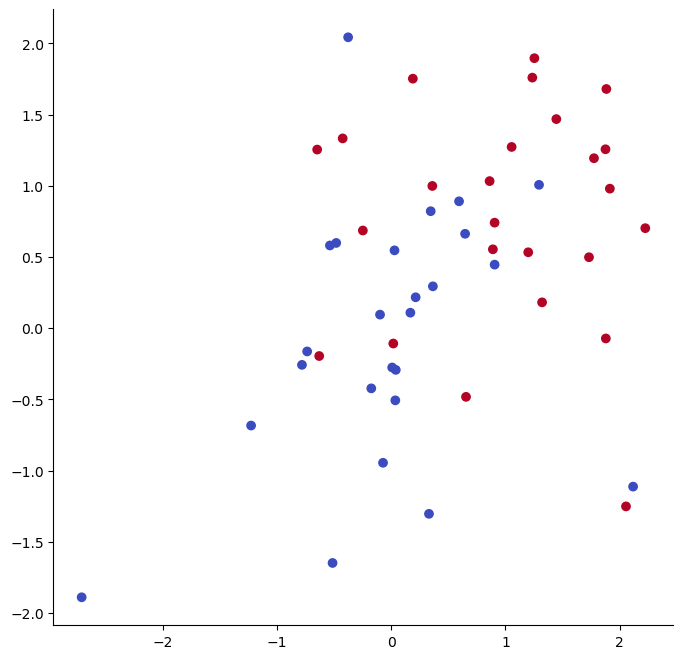

In [5]:
rng = np.random.default_rng(1)
X = rng.standard_normal((50, 2))
y = np.array([-1]*25+[1]*25)
X[y==1] += 1
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0],
           X[:,1],
           c=y,
           cmap=cm.coolwarm);
sns.despine()

They are not.  We now fit the classifier.

In [6]:
svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X, y)

SVC(C=10, kernel='linear')

The support vector classifier with two features can
be visualized by plotting values of its *decision function*.
We have included a function for this in the `ISLP` package (inspired by a similar
example in the `sklearn` docs).

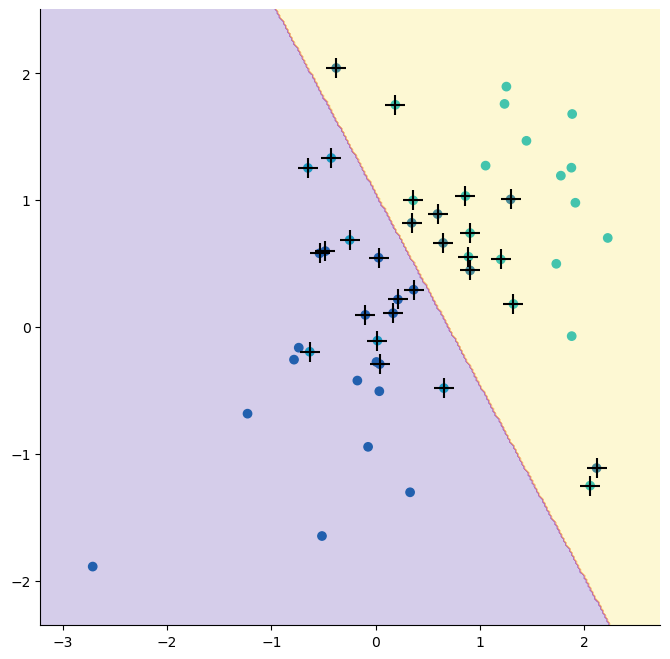

In [7]:
plot_svm(X,
         y,
         svm_linear)
sns.despine()

The decision
boundary between the two classes is linear (because we used the
argument `kernel='linear'`). The support vectors are marked with `+`
and the remaining observations are plotted as circles.

What if we instead used a smaller value of the cost parameter?

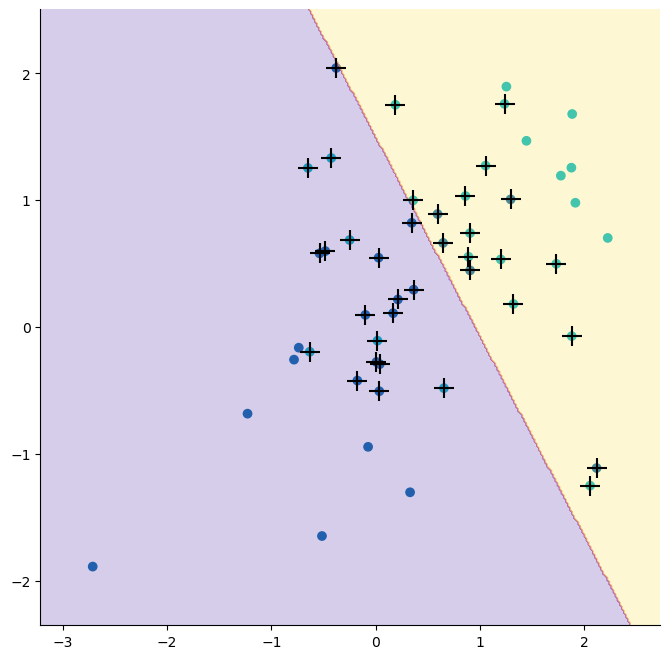

In [8]:
svm_linear_small = SVC(C=0.1, kernel='linear')
svm_linear_small.fit(X, y)
plot_svm(X,
         y,
         svm_linear_small)
sns.despine()

With  a smaller value of the cost parameter, we
obtain a larger number of support vectors, because the margin is now
wider. For linear kernels, we can extract the
coefficients of the linear decision boundary as follows:

In [9]:
svm_linear.coef_

array([[1.17303943, 0.77348227]])

Since the support vector machine is an estimator in `sklearn`, we
can use the usual machinery to tune it.

In [10]:
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.001,0.01,0.1,1,5,10,100]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X, y)
grid.best_params_

{'C': 1}

We can easily access the cross-validation errors for each of these models
in  `grid.cv_results_`. This prints out a lot of detail, so we
extract the accuracy results only.

In [11]:
grid.cv_results_[('mean_test_score')]

array([0.46, 0.46, 0.72, 0.74, 0.74, 0.74, 0.74])

We see that  `C=1` results in the highest cross-validation
accuracy of 0.74, though
the accuracy is the same for several values of `C`.
The classifier `grid.best_estimator_` can be used to predict the class
label on a set of test observations. Let’s generate a test data set.

In [12]:
X_test = rng.standard_normal((20, 2))
y_test = np.array([-1]*10+[1]*10)
X_test[y_test==1] += 1

Now we predict the class labels of these test observations. Here we
use the best model selected by cross-validation in order to make the
predictions.

In [13]:
best_ = grid.best_estimator_
y_test_hat = best_.predict(X_test)
confusion_table(y_test_hat, y_test)

Truth,-1,1
Predicted,,
-1,8,4
1,2,6


Thus, with this value of `C`,
70% of the test
observations are correctly classified.  What if we had instead used
`C=0.001`?

In [14]:
svm_ = SVC(C=0.001,
           kernel='linear').fit(X, y)
y_test_hat = svm_.predict(X_test)
confusion_table(y_test_hat, y_test)

Truth,-1,1
Predicted,,
-1,2,0
1,8,10


In this case 60% of test observations are correctly classified.

We now consider a situation in which the two classes are linearly
separable. Then we can find an optimal separating hyperplane using the
`SVC()` estimator.  We first
further separate the two classes in our simulated data so that they
are linearly separable:

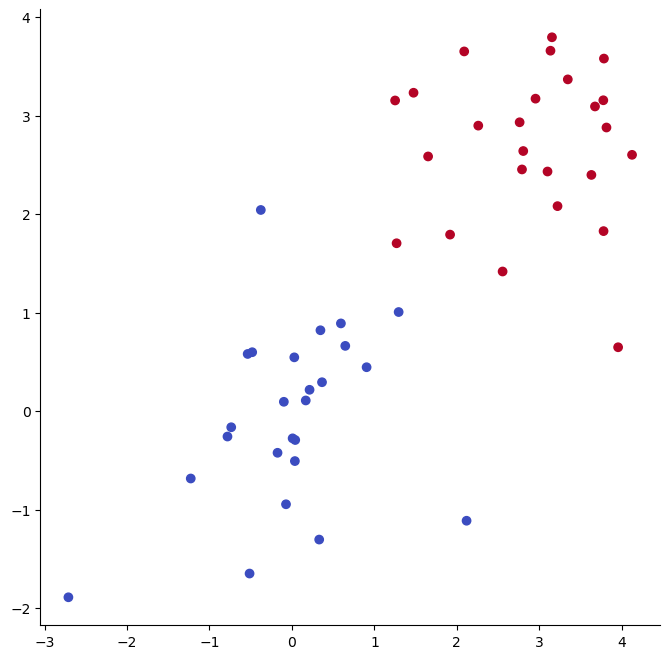

In [15]:
X[y==1] += 1.9;
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm);
sns.despine()

Now the observations are just barely linearly separable.

In [16]:
svm_ = SVC(C=1e5, kernel='linear').fit(X, y)
y_hat = svm_.predict(X)
confusion_table(y_hat, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


We fit the
support vector classifier and plot the resulting hyperplane, using a
very large value of `C` so that no observations are
misclassified. 

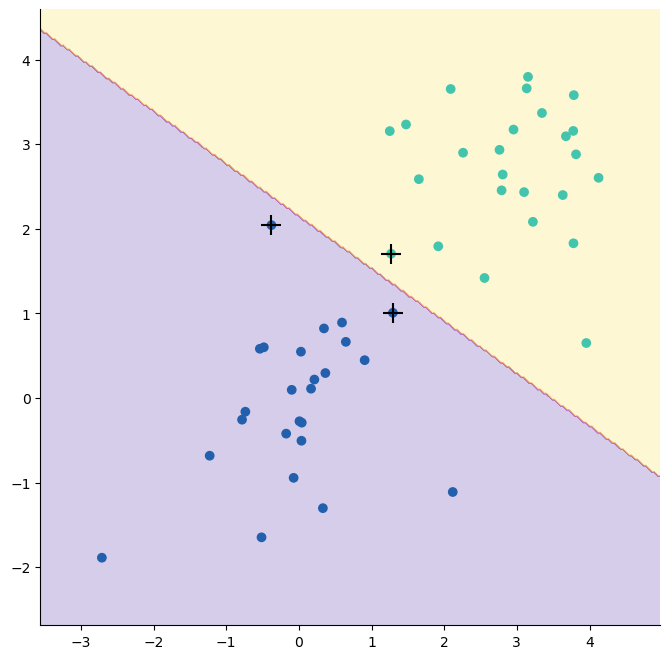

In [17]:
plot_svm(X,
         y,
         svm_)
sns.despine()

Indeed no training errors were made and only three support vectors were used.
In fact, the large value of `C` also means that these three support points are *on the margin*, and define it.
One may wonder how good the classifier could be on test data that depends on only three data points!
 We now try a smaller
value of `C`.

In [18]:
svm_ = SVC(C=0.1, kernel='linear').fit(X, y)
y_hat = svm_.predict(X)
confusion_table(y_hat, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


Using `C=0.1`, we again do not misclassify any training observations, but we
also obtain a much wider margin and make use of twelve support
vectors. These jointly define the orientation of the decision boundary, and since there are more of them, it is more stable. It seems possible that this model will perform better on test
data than the model with `C=1e5` (and indeed, a simple experiment with a large test set would bear this out).

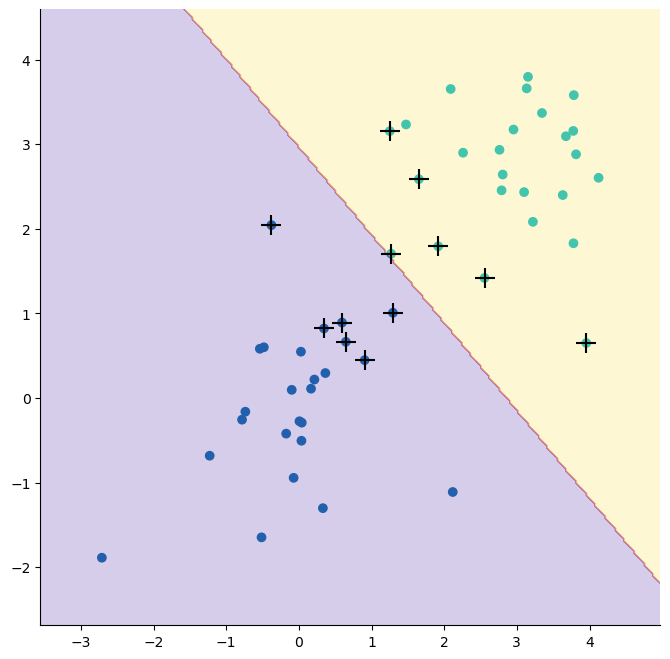

In [19]:
plot_svm(X,
         y,
         svm_)
sns.despine()

## Support Vector Machine
In order to fit an SVM using a non-linear kernel, we once again use
the `SVC()`  estimator. However, now we use a different value
of the parameter `kernel`. To fit an SVM with a polynomial
kernel we use `kernel="poly"`, and to fit an SVM with a
radial kernel  we use
`kernel="rbf"`.  In the former case we also use the
`degree` argument to specify a degree for the polynomial kernel
(this is $d$ in (9.22)), and in the latter case we use
`gamma` to specify a value of $\gamma$ for the radial basis
kernel  (9.24).

We first generate some data with a non-linear class boundary, as follows:

In [20]:
X = rng.standard_normal((200, 2))
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)

Plotting the data makes it clear that the class boundary is indeed non-linear.

In [21]:
ax.scatter(X[:,0],
           X[:,1],
           c=y,
           cmap=cm.coolwarm)

The data is randomly split into training and testing groups. We then
fit the training data using the `SVC()`  estimator with a
radial kernel and $\gamma=1$:

In [22]:
(X_train, 
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                y,
                                test_size=0.5,
                                random_state=0)
svm_rbf = SVC(kernel="rbf", gamma=1, C=1)
svm_rbf.fit(X_train, y_train)

SVC(C=1, gamma=1)

The plot shows that the resulting SVM has a decidedly non-linear
boundary. 

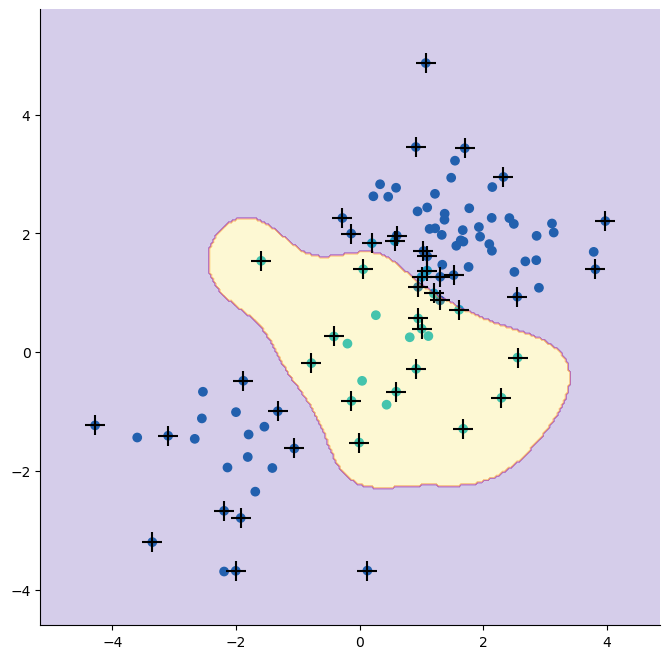

In [23]:
plot_svm(X_train,
         y_train,
         svm_rbf)
sns.despine()

We can see from the figure that there are a fair number of training
errors in this SVM fit.  If we increase the value of `C`, we
can reduce the number of training errors. However, this comes at the
price of a more irregular decision boundary that seems to be at risk
of overfitting the data.

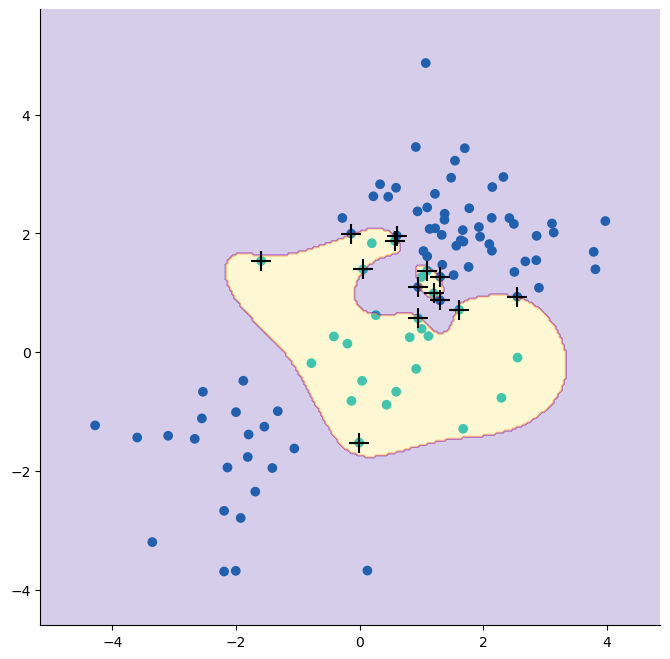

In [24]:
svm_rbf = SVC(kernel="rbf", gamma=1, C=1e5)
svm_rbf.fit(X_train, y_train)
plot_svm(X_train,
         y_train,
         svm_rbf)
sns.despine()

We can perform cross-validation using `skm.GridSearchCV()`  to select the
best choice of $\gamma$ and `C` for an SVM with a radial
kernel:

In [25]:
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_rbf,
                        {'C':[0.1,1,10,100,1000],
                         'gamma':[0.5,1,2,3,4]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy');
grid.fit(X_train, y_train)
grid.best_params_


{'C': 1, 'gamma': 0.5}

The best choice of parameters under five-fold CV is achieved at `C=1`
and `gamma=0.5`, though several other values also achieve the same
value.

Truth,1,2
Predicted,,
1,69,6
2,6,19


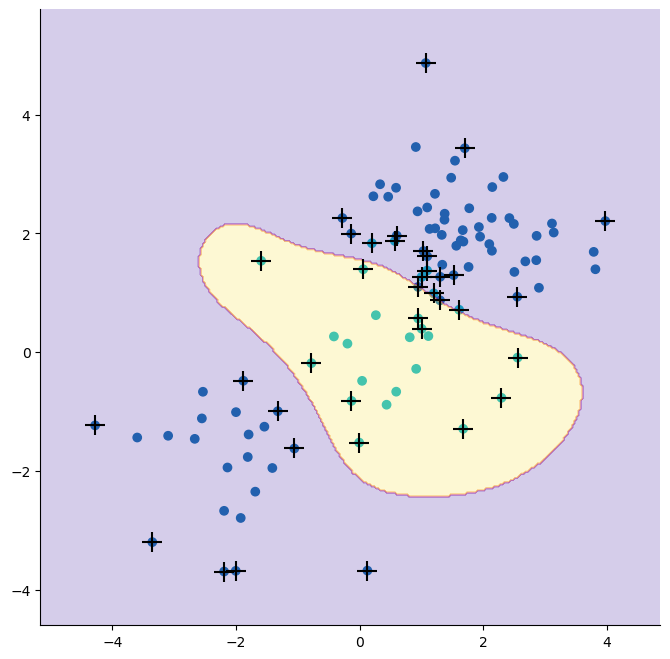

In [26]:
best_svm = grid.best_estimator_
plot_svm(X_train,
         y_train,
         best_svm)
sns.despine()

y_hat_test = best_svm.predict(X_test)
confusion_table(y_hat_test, y_test)

With these parameters, 12% of test
observations are misclassified by this SVM.

## ROC Curves

SVMs and support vector classifiers output class labels for each
observation. However, it is also possible to obtain *fitted values*
for each observation, which are the numerical scores used to
obtain the class labels. For instance, in the case of a support vector
classifier, the fitted value for an observation $X= (X_1, X_2, \ldots,
X_p)^T$ takes the form $\hat{\beta}_0 + \hat{\beta}_1 X_1 +
\hat{\beta}_2 X_2 + \ldots + \hat{\beta}_p X_p$. For an SVM with a
non-linear kernel, the equation that yields the fitted value is given
in  (9.23). The sign of the fitted value
determines on which side of the decision boundary the observation
lies. Therefore, the relationship between the fitted value and the
class prediction for a given observation is simple: if the fitted
value exceeds zero then the observation is assigned to one class, and
if it is less than zero then it is assigned to the other.
By changing this threshold from zero to some positive value,
we skew the classifications in favor of one class versus the other.
By considering a range of these thresholds, positive and negative, we produce the ingredients for a ROC plot.
We can access these values by calling the `decision_function()`
method of a fitted SVM estimator.

The function `ROCCurveDisplay.from_estimator()` (which we have abbreviated to `roc_curve()`) will produce a plot of a ROC curve. It takes a fitted estimator as its first argument, followed
by a model matrix $X$ and labels $y$. The argument `name` is used in the legend,
while `color` is used for the color of the line. Results are plotted
on our axis object `ax`.

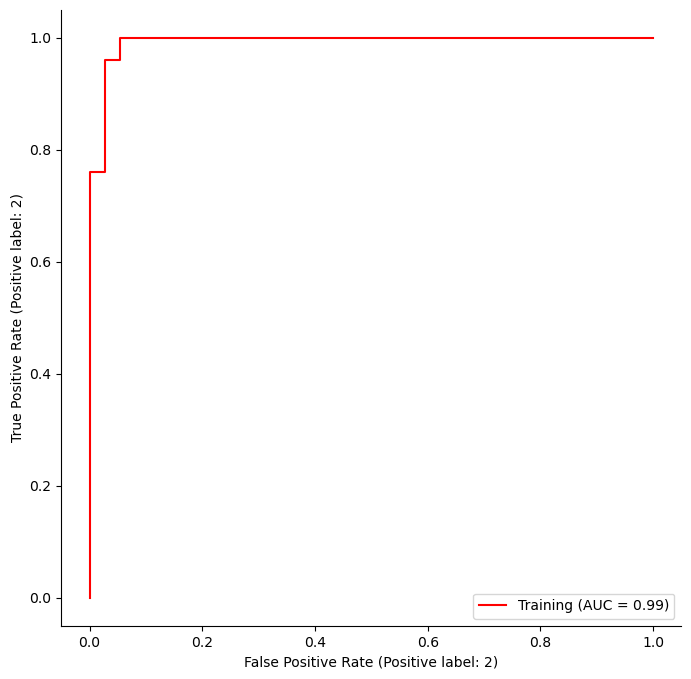

In [27]:
fig, ax = subplots(figsize=(8,8))
roc_curve(best_svm,
          X_train,
          y_train,
          name='Training',
          color='r',
          ax=ax);
sns.despine()

 In this example, the SVM appears to provide accurate predictions. By increasing
$\gamma$ we can produce a more flexible fit and generate further
improvements in accuracy.

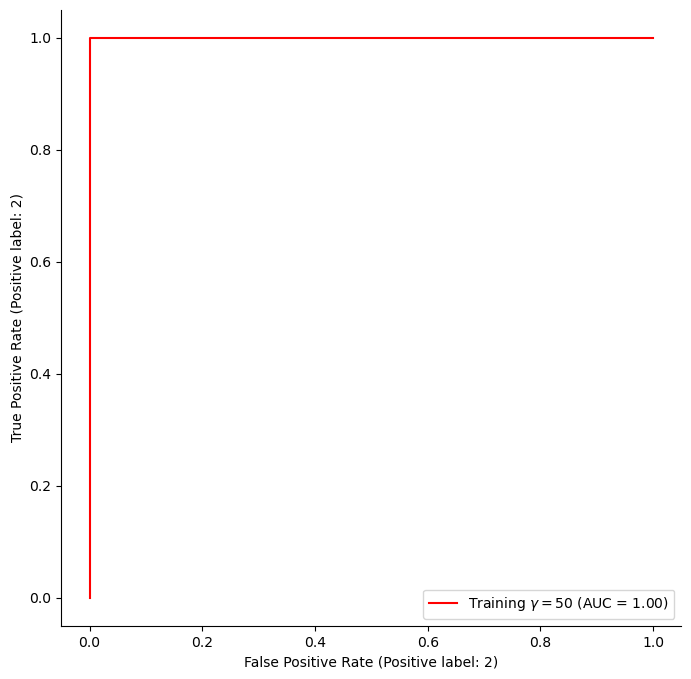

In [28]:
svm_flex = SVC(kernel="rbf", 
              gamma=50,
              C=1)
svm_flex.fit(X_train, y_train)
fig, ax = subplots(figsize=(8,8))
roc_curve(svm_flex,
          X_train,
          y_train,
          name='Training $\gamma=50$',
          color='r',
          ax=ax);
sns.despine()

However, these ROC curves are all on the training data. We are really
more interested in the level of prediction accuracy on the test
data. When we compute the ROC curves on the test data, the model with
$\gamma=0.5$ appears to provide the most accurate results.

In [29]:
roc_curve(svm_flex,
          X_test,
          y_test,
          name='Test $\gamma=50$',
          color='b',
          ax=ax)
fig;

Let’s look at our tuned SVM.

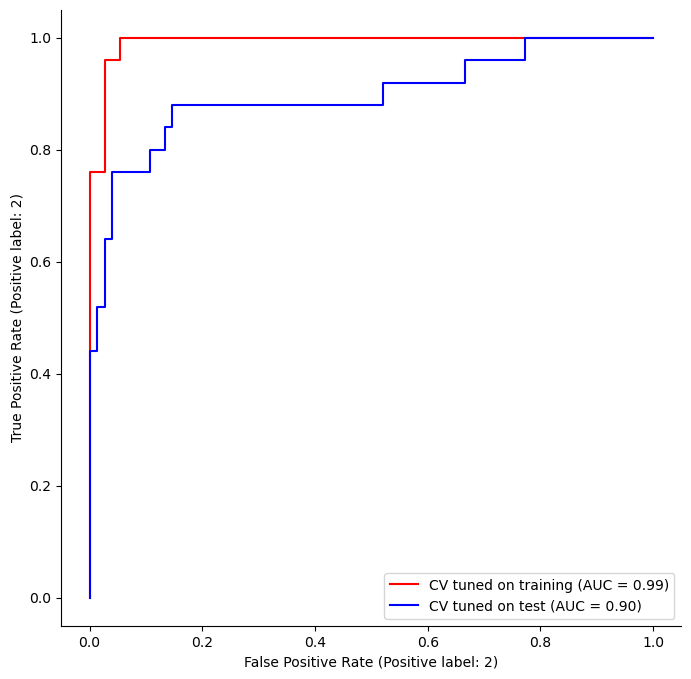

In [30]:
fig, ax = subplots(figsize=(8,8))
for (X_, y_, c, name) in zip(
     (X_train, X_test),
     (y_train, y_test),
     ('r', 'b'),
     ('CV tuned on training',
      'CV tuned on test')):
    roc_curve(best_svm,
              X_,
              y_,
              name=name,
              ax=ax,
              color=c)
sns.despine()

## SVM with Multiple Classes

If the response is a factor containing more than two levels, then the
`SVC()`  function will perform multi-class classification using
either the one-versus-one approach (when `decision_function_shape=='ovo'`)
or one-versus-rest {One-versus-rest is also known as one-versus-all.} (when `decision_function_shape=='ovr'`).
We explore that setting briefly here by
generating a third class of observations.

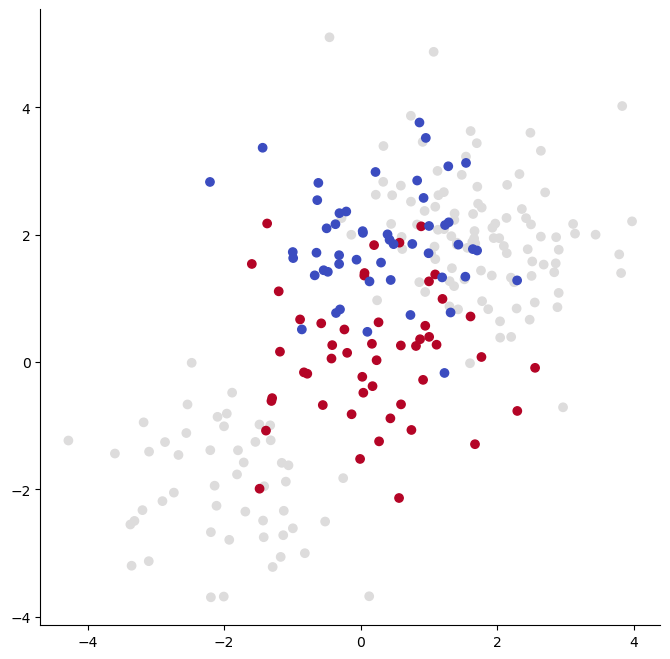

In [31]:
rng = np.random.default_rng(123)
X = np.vstack([X, rng.standard_normal((50, 2))])
y = np.hstack([y, [0]*50])
X[y==0,1] += 2
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm);
sns.despine()

We now fit an SVM to the data:

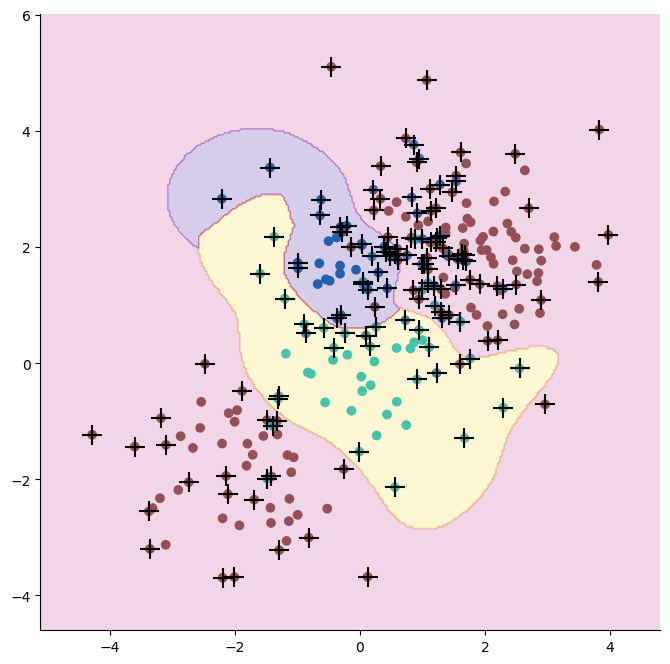

In [32]:
svm_rbf_3 = SVC(kernel="rbf",
                C=10,
                gamma=1,
                decision_function_shape='ovo');
svm_rbf_3.fit(X, y)
plot_svm(X,
         y,
         svm_rbf_3,
         scatter_cmap=cm.tab10)
sns.despine()

The `sklearn.svm` library can also be used to perform support vector
regression with a numerical response using the  estimator `SupportVectorRegression()`.

## Application to Gene Expression Data

We now examine the `Khan` data set, which consists of a number of
tissue samples corresponding to four distinct types of small round
blue cell tumors. For each tissue sample, gene expression measurements
are available.  The data set consists of training data, `xtrain`
and `ytrain`, and testing data, `xtest` and `ytest`.

We examine the dimension of the data:

In [33]:
Khan = load_data('Khan')
Khan['xtrain'].shape, Khan['xtest'].shape


((63, 2308), (20, 2308))

This data set consists of expression measurements for 2,308
genes. The training and test sets consist of 63 and 20
observations, respectively.

We will use a support vector approach to predict cancer subtype using
gene expression measurements.  In this data set, there is a very
large number of features relative to the number of observations. This
suggests that we should use a linear kernel, because the additional
flexibility that will result from using a polynomial or radial kernel 
is unnecessary. 

In [34]:
khan_linear = SVC(kernel='linear', C=10)
khan_linear.fit(Khan['xtrain'], Khan['ytrain'])
confusion_table(khan_linear.predict(Khan['xtrain']),
                Khan['ytrain'])

Truth,1,2,3,4
Predicted,,,,
1,8,0,0,0
2,0,23,0,0
3,0,0,12,0
4,0,0,0,20


We  see that there are *no* training
errors. In fact, this is not surprising, because the large number of
variables relative to the number of observations implies that it is
easy to find hyperplanes that fully separate the classes. We are more
interested in the support vector classifier’s performance on the
test observations.

In [35]:
confusion_table(khan_linear.predict(Khan['xtest']),
                Khan['ytest'])

Truth,1,2,3,4
Predicted,,,,
1,3,0,0,0
2,0,6,2,0
3,0,0,4,0
4,0,0,0,5


We see that using `C=10` yields two test set errors on these data.

